In [1]:
# Leitura de Pacotes
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from string import ascii_letters
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
from scipy import stats
from pandas import read_csv
from scipy.stats import uniform, randint
from pandas.plotting import scatter_matrix
from scipy.stats import norm, skew
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Lendo a base de dados
dataset_treino = pd.read_csv("../input/dataset_treino.csv", index_col = "Order")
dataset_teste = pd.read_csv("../input/dataset_teste.csv", index_col = "OrderId")

**Análise Exploratória e Preparação dos Dados**

In [3]:
# Visualização dos dados
dataset_treino.head(5)

,Property Id,Property Name,Parent Property Id,Parent Property Name,BBL - 10 digits,"NYC Borough, Block and Lot (BBL) self-reported",NYC Building Identification Number (BIN),Address 1 (self-reported),Address 2,Postal Code,Street Number,Street Name,Borough,DOF Gross Floor Area,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,Largest Property Use Type - Gross Floor Area (ft²),2nd Largest Property Use Type,2nd Largest Property Use - Gross Floor Area (ft²),3rd Largest Property Use Type,3rd Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,Metered Areas (Energy),Metered Areas (Water),ENERGY STAR Score,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Weather Normalized Source EUI (kBtu/ft²),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),District Steam Use (kBtu),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Property GFA - Self-Reported (ft²),Water Use (All Water Sources) (kgal),Water Intensity (All Water Sources) (gal/ft²),Source EUI (kBtu/ft²),Release Date,Water Required?,DOF Benchmarking Submission Status,Latitude,Longitude,Community Board,Council District,Census Tract,NTA
Order,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
21,2780056,720-730 Ft. Washington Owners Corp.,2780056,720-730 Ft. Washington Owners Corp.,1021800614;1021800628,1021800614;1021800628,1064475;1064476;1803806,720-730 Ft. Washington Ave.,Not Available,10040,NaN,NaN,NaN,NaN,Multifamily Housing,Multifamily Housing,Multifamily Housing,321464.0,Not Available,Not Available,Not Available,Not Available,1939,2,100,Whole Building,Whole Building,72,76.2,79.9,3.5,0,106.2,Not Available,Not Available,1.96354077E7,Not Available,Not Available,Not Available,880200,8906.3,3968641.7,1121931.8,1893.4,1525.1,368.3,321464,5915.6,18.4,103.3,05/01/2017 10:09:31 PM,Yes,In Compliance,NaN,NaN,NaN,NaN,NaN,NaN
22,4988574,- 720 Ft. Washington Ave. bldg,2780056,720-730 Ft. Washington Owners Corp.,1021800614,1021800614,1064475,720-730 Ft. Washington Ave.,Not Available,10040,720,FT WASHINGTON AVENUE,Manhattan,179130.0,Multifamily Housing,Multifamily Housing,Multifamily Housing,204720.0,Not Available,Not Available,Not Available,Not Available,1939,1,100,Whole Building,Not Available,67,75.7,79,4,0,109.1,Not Available,Not Available,1.20478901E7,Not Available,Not Available,Not Available,553439.4,5604.4,2886852.2,820016.2,1204.4,936.5,267.9,204720,Not Available,Not Available,106.6,05/01/2017 10:09:31 PM,NaN,In Compliance,40.857943,-73.934962,12.0,10.0,281.0,Washington Heights North ...
24,2806486,Park 76th Street Inc.,2806486,Park 76th Street Inc.,1013900037;1013910034,1013900037;1013910034,1041702; 1041800,830-840 Park Avenue,Not Available,10021,NaN,NaN,NaN,NaN,Multifamily Housing,Multifamily Housing,Multifamily Housing,189766.0,Not Available,Not Available,Not Available,Not Available,1911,2,100,Whole Building,Whole Building,100,68.0,Not Available,6.1,0.5,Not Available,Not Available,112138.8,Not Available,Not Available,Not Available,Not Available,8786386.9,98264.5,4013954.9,1156269.9,847.5,475,372.5,189766,Not Available,Not Available,115.6,05/01/2017 10:09:31 PM,Yes,In Compliance,NaN,NaN,NaN,NaN,NaN,NaN
25,4988686,- 830 Park Avenue bldg,2806486,Park 76th Street Inc.,1013900037,1013900037,1041702,830 Park Avenue,Not Available,10021,830,PARK AVENUE,Manhattan,151666.0,Multifamily Housing,Multifamily Housing,Multifamily Housing,130629.0,Not Available,Not Available,Not Available,Not Available,1911,1,100,Another configuration,Not Available,100,23.7,23.4,6.8,Not Av

In [4]:
# Shape do Dado
dataset_treino.shape

(6622, 59)

In [5]:
# Tipos de Dados
print(dataset_treino.dtypes)

Property Id                                                     int64
Property Name                                                  object
Parent Property Id                                             object
Parent Property Name                                           object
BBL - 10 digits                                                object
NYC Borough, Block and Lot (BBL) self-reported                 object
NYC Building Identification Number (BIN)                       object
Address 1 (self-reported)                                      object
Address 2                                                      object
Postal Code                                                    object
Street Number                                                  object
Street Name                                                    object
Borough                                                        object
DOF Gross Floor Area                                          float64
Primary Property Typ

In [6]:
# Vendo as Colunas dos Dados
dataset_treino.columns

Index(['Property Id', 'Property Name', 'Parent Property Id',
       'Parent Property Name', 'BBL - 10 digits',
       'NYC Borough, Block and Lot (BBL) self-reported',
       'NYC Building Identification Number (BIN)', 'Address 1 (self-reported)',
       'Address 2', 'Postal Code', 'Street Number', 'Street Name', 'Borough',
       'DOF Gross Floor Area', 'Primary Property Type - Self Selected',
       'List of All Property Use Types at Property',
       'Largest Property Use Type',
       'Largest Property Use Type - Gross Floor Area (ft²)',
       '2nd Largest Property Use Type',
       '2nd Largest Property Use - Gross Floor Area (ft²)',
       '3rd Largest Property Use Type',
       '3rd Largest Property Use Type - Gross Floor Area (ft²)', 'Year Built',
       'Number of Buildings - Self-reported', 'Occupancy',
       'Metered Areas (Energy)', 'Metered Areas  (Water)', 'ENERGY STAR Score',
       'Site EUI (kBtu/ft²)', 'Weather Normalized Site EUI (kBtu/ft²)',
       'Weather Normal

In [7]:
# Retirando colunas que não serão utilizadas
dataset_treino = dataset_treino.drop(["Property Id","Property Name","Parent Property Id",
                                      "Parent Property Name", "NYC Borough, Block and Lot (BBL) self-reported", 
                                      "NYC Building Identification Number (BIN)","Postal Code",
                                      "Street Number","Street Name",
                                      "Borough", "Address 1 (self-reported)", 'Address 2'],
                                      axis = 1)

In [8]:
# Retirando as Variaveis Categoricas com muitos NA
dataset_treino = dataset_treino.drop(["2nd Largest Property Use Type",
                                      "2nd Largest Property Use - Gross Floor Area (ft²)","3rd Largest Property Use Type",
                                      "3rd Largest Property Use Type - Gross Floor Area (ft²)", "Fuel Oil #1 Use (kBtu)",
                                      "Fuel Oil #2 Use (kBtu)", "Fuel Oil #4 Use (kBtu)", "Fuel Oil #5 & 6 Use (kBtu)",
                                      "Diesel #2 Use (kBtu)", "District Steam Use (kBtu)", "DOF Benchmarking Submission Status"], axis = 1)

In [9]:
# Retirando colunas duplicas
dataset_treino = dataset_treino.drop(["Largest Property Use Type","List of All Property Use Types at Property"], axis = 1)

In [10]:
# Criando uma nova coluna com os "Borough"
dataset_treino['BBL - 10 digits'] = dataset_treino['BBL - 10 digits'].astype('category')
dataset_treino['BBL - 10 digits'] = dataset_treino['BBL - 10 digits'].apply(lambda x: x[0]).astype('category')

dataset_teste['BBL - 10 digits'] = dataset_teste['BBL - 10 digits'].astype('category')
dataset_teste['BBL - 10 digits'] = dataset_teste['BBL - 10 digits'].apply(lambda x: x[0]).astype('category')

In [11]:
# Substituindo os Valores Faltantes por 0.001
# Dados de Treino
dataset_treino = dataset_treino.where((pd.notnull(dataset_treino)), 0.001)
d = {'Not Available': 0.001}
df = dataset_treino.replace(d)

# Dados de Teste
dataset_teste = dataset_teste.where((pd.notnull(dataset_teste)), 0.001)
df_teste = dataset_teste.replace(d)

In [12]:
# Colunas Numericas com Valores Faltantes
colunas = ["Year Built", "Site EUI (kBtu/ft²)","Weather Normalized Site EUI (kBtu/ft²)",
           "Weather Normalized Site Electricity Intensity (kWh/ft²)","Weather Normalized Site Natural Gas Intensity (therms/ft²)",
           "Natural Gas Use (kBtu)","Weather Normalized Site Electricity (kWh)","Total GHG Emissions (Metric Tons CO2e)",
           "Direct GHG Emissions (Metric Tons CO2e)","Indirect GHG Emissions (Metric Tons CO2e)",
           "Water Use (All Water Sources) (kgal)","Water Intensity (All Water Sources) (gal/ft²)","Source EUI (kBtu/ft²)",
          "Weather Normalized Site Natural Gas Use (therms)", "Electricity Use - Grid Purchase (kBtu)",
          "Natural Gas Use (kBtu)", "Weather Normalized Site Natural Gas Use (therms)","Weather Normalized Source EUI (kBtu/ft²)",
          "DOF Gross Floor Area","Number of Buildings - Self-reported", "Census Tract",
           "Largest Property Use Type - Gross Floor Area (ft²)","Property GFA - Self-Reported (ft²)","Occupancy",
           "Council District","Community Board"]
array = df[colunas].values
                                      
array_teste = df_teste[colunas].values

In [13]:
# Transformando o array em float
array = array.astype(float)

array_teste = array_teste.astype(float)

In [14]:
# Imputando os Dados Faltantes pela Media dos Dados
imp = SimpleImputer(missing_values = 0.001, strategy = 'median').fit(array)  
dataset_treino[colunas] = imp.transform(array)

dataset_teste[colunas] = imp.transform(array_teste)

In [15]:
# Visualizando Novamente os Dados
dataset_treino.head(5)

,BBL - 10 digits,DOF Gross Floor Area,Primary Property Type - Self Selected,Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,Metered Areas (Energy),Metered Areas (Water),ENERGY STAR Score,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Weather Normalized Source EUI (kBtu/ft²),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Property GFA - Self-Reported (ft²),Water Use (All Water Sources) (kgal),Water Intensity (All Water Sources) (gal/ft²),Source EUI (kBtu/ft²),Release Date,Water Required?,Latitude,Longitude,Community Board,Council District,Census Tract,NTA
Order,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
21,1,91616.0,Multifamily Housing,321464.0,1939.0,2.0,100.0,Whole Building,Whole Building,72,76.2,79.9,3.5,0.0,106.2,880200.00,8906.3,3968641.7,1121931.8,1893.4,1525.1,368.3,321464.0,5915.60,18.40,103.3,05/01/2017 10:09:31 PM,Yes,0.001000,0.001000,7.0,10.0,218.0,0.001
22,1,179130.0,Multifamily Housing,204720.0,1939.0,1.0,100.0,Whole Building,Not Available,67,75.7,79.0,4.0,0.0,109.1,553439.40,5604.4,2886852.2,820016.2,1204.4,936.5,267.9,204720.0,4851.55,46.75,106.6,05/01/2017 10:09:31 PM,0.001,40.857943,-73.934962,12.0,10.0,281.0,Washington Heights North ...
24,1,91616.0,Multifamily Housing,189766.0,1911.0,2.0,100.0,Whole Building,Whole Building,100,68.0,82.6,6.1,0.5,128.3,8786386.90,98264.5,4013954.9,1156269.9,847.5,475.0,372.5,189766.0,4851.55,46.75,115.6,05/01/2017 10:09:31 PM,Yes,0.001000,0.001000,7.0,10.0,218.0,0.001
25,1,151666.0,Multifamily Housing,130629.0,1911.0,1.0,100.0,Another configuration,Not Available,100,23.7,23.4,6.8,0.5,73.3,4191219.85,45346.5,3090622.7,894049.0,286.8,0.0,286.8,130629.0,4851.55,46.75,74.3,05/01/2017 10:09:31 PM,0.001,40.773465,-73.962116,8.0,4.0,130.0,Upper East Side-Carnegie Hill ...
26,1,64827.0,Multifamily Housing,54913.0,1911.0,1.0,100.0,Another configuration,Not Available,100,17.9,17.4,4.8,0.0,52.3,59412.90,601.0,923332.2,262377.2,88.8,3.2,85.7,54913.0,231.90,4.22,53.9,05/01/2017 10:09:31 PM,Yes,40.773843,-73.961838,8.0,4.0,130.0,Upper East Side-Carnegie Hill ...


In [16]:
# Descrição dos dados
dataset_treino.describe()

,DOF Gross Floor Area,Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,ENERGY STAR Score,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Weather Normalized Source EUI (kBtu/ft²),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Property GFA - Self-Reported (ft²),Water Use (All Water Sources) (kgal),Water Intensity (All Water Sources) (gal/ft²),Source EUI (kBtu/ft²),Latitude,Longitude,Community Board,Council District,Census Tract
count,6.622000e+03,6.622000e+03,6622.000000,6622.000000,6622.000000,6622.000000,6622.000000,6622.000000,6622.000000,6622.000000,6622.000000,6.622000e+03,6.622000e+03,6.622000e+03,6.622000e+03,6622.000000,6622.000000,6622.000000,6.622000e+03,6.622000e+03,6622.000000,6622.000000,6622.000000,6622.000000,6622.000000,6622.000000,6622.000000
mean,1.608274e+05,1.547783e+05,1948.317729,1.285563,99.017668,60.477348,80.122350,83.928375,6.881471,0.480474,137.260601,6.023405e+06,6.319473e+04,4.726932e+06,1.355589e+06,931.951752,405.629130,526.701389,1.598433e+05,1.085022e+04,89.018436,133.982936,33.049011,-59.973117,7.278315,15.208245,4130.824222
std,2.563986e+05,2.340884e+05,29.885053,3.892317,5.666364,29.440291,32.013067,31.397428,5.142301,0.325191,56.798870,1.777824e+07,1.771000e+05,1.123236e+07,3.263172e+06,1850.829475,1037.607076,1480.487932,2.439364e+05,7.882005e+04,562.240323,59.484419,15.958713,28.960903,3.561700,14.505325,11883.802326
min,5.002800e+04,3.800000e+03,1649.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,1.200000e+02,0.000000e+00,0.000000,0.000000,0.001000,-74.224464,1.000000,1.000000,1.000000
25%,6.525000e+04,6.600000e+04,1927.000000,1.000000,100.000000,38.000000,62.700000,68.600000,3.800000,0.200000,107.200000,1.669072e+06,2.057812e+04,1.024838e+06,3.027619e+05,334.725000,170.225000,94.025000,6.700000e+04,3.662700e+03,37.330000,100.000000,40.617657,-73.979448,5.000000,4.000000,129.000000
50%,9.161600e+04,9.100000e+04,1940.000000,1.000000,100.000000,66.000000,78.500000,82.600000,5.100000,0.500000,128.300000,4.191220e+06,4.534650e+04,1.761624e+06,5.144488e+05,498.900000,279.600000,164.300000,9.299800e+04,4.851550e+03,46.750000,123.650000,40.744781,-73.953610,7.000000,10.000000,218.000000
75%,1.545135e+05,1.514815e+05,1964.000000,1.000000,100.000000,86.000000,95.900000,98.500000,8.200000,0.700000,156.700000,6.294287e+06,6.559520e+04,4.010613e+06,1.118168e+06,852.900000,444.625000,384.975000,1.554812e+05,6.231875e+03,58.110000,157.200000,40.800606,-73.885272,9.000000,16.000000,430.000000
max,8.512479e+06,6.940450e+06,2019.000000,140.000000,100.000000,100.000000,204.800000,219.500000,51.000000,1.900000,576.800000,1.048344e+09,1.048344e+07,2.568652e+08,7.450618e+07,63451.100000,63451.100000,32950.500000,6.940450e+06,2.775784e+06,21689.360000,576.800000,40.911797,0.001000,18.000000,51.000000,105804.000000


In [17]:
# Correlação
dataset_treino.corr(method = 'pearson')

,DOF Gross Floor Area,Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,ENERGY STAR Score,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Weather Normalized Source EUI (kBtu/ft²),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Property GFA - Self-Reported (ft²),Water Use (All Water Sources) (kgal),Water Intensity (All Water Sources) (gal/ft²),Source EUI (kBtu/ft²),Latitude,Longitude,Community Board,Council District,Census Tract
DOF Gross Floor Area,1.000000,0.896670,0.138108,0.054563,-0.057487,0.003074,0.040068,0.023553,0.214505,-0.057609,0.150304,0.480099,0.421518,0.704676,0.681535,0.815037,0.476547,0.684669,0.903750,0.062923,-0.011616,0.158574,0.026497,-0.026734,-0.141843,-0.132616,-0.032405
Largest Property Use Type - Gross Floor Area (ft²),0.896670,1.000000,0.128308,0.066585,-0.061738,0.014289,0.033005,0.017383,0.197665,-0.056694,0.135899,0.575207,0.560204,0.738877,0.726534,0.897854,0.569000,0.723417,0.993997,0.059457,-0.014904,0.145634,0.020190,-0.020458,-0.141565,-0.140268,-0.040159
Year Built,0.138108,0.128308,1.000000,0.022434,0.001045,-0.121421,-0.002224,-0.012009,0.122294,0.070376,0.076492,0.083127,0.085495,0.121481,0.120585,0.111918,0.043619,0.109311,0.129072,0.042245,0.004925,0.079919,-0.122492,0.122050,-0.042461,0.082663,-0.017089
Number of Buildings - Self-reported,0.054563,0.066585,0.022434,1.000000,0.008920,-0.020088,0.007724,0.009652,-0.024348,0.055250,-0.010284,0.107317,0.110520,-0.002261,-0.003347,0.052118,0.101494,-0.005876,0.062600,-0.000316,-0.003107,-0.013941,-0.104369,0.104293,0.003505,-0.000296,-0.008129
Occupancy,-0.057487,-0.061738,0.001045,0.008920,1.000000,-0.042779,0.054838,0.036411,-0.069178,0.044752,-0.025690,0.011843,0.012606,-0.078668,-0.079039,-0.050324,0.022790,-0.079604,-0.063886,-0.063266,-0.044303,-0.014422,-0.008069,0.008268,0.076748,0.053721,0.025678
ENERGY STAR Score,0.003074,0.014289,-0.121421,-0.020088,-0.042779,1.000000,-0.725326,-0.680765,-0.349303,-0.319031,-0.614897,-0.127022,-0.126776,-0.050170,-0.048542,-0.114751,-0.142957,-0.043018,0.013894,-0.014310,-0.006766,-0.639500,-0.033669,0.033428,0.045148,0.045712,-0.000231
Site EUI (kBtu/ft²),0.040068,0.033005,-0.002224,0.007724,0.054838,-0.725326,1.000000,0.941970,0.354645,0.446309,0.769205,0.171985,0.166766,0.130796,0.127632,0.227247,0.213221,0.134272,0.036530,0.020979,0.011591,0.800262,0.004111,-0.003867,0.021174,-0.030042,0.015990
Weather Normalized Site EUI (kBtu/ft²),0.023553,0.017383,-0.012009,0.009652,0.036411,-0.680765,0.941970,1.000000,0.328080,0.458807,0.793860,0.158253,0.163909,0.106684,0.106218,0.201313,0.200450,0.111130,0.019712,0.026918,0.023308,0.740597,-0.009072,0.009316,0.024482,-0.024212,0.021105
Weather Normalized Site Electricity Intensity (kWh/ft²),0.214505,0.197665,0.122294,-0.024348,-0.069178,-0.349303,0.354645,0.328080,1.000000,-0.138925,0.818805,-0.012929,-0.012172,0.473788,0.476274,0.315686,-0.030853,0.416233,0.216519,0.019676,-0.005226,0.828866,0.130719,-0.131372,-0.296325,-0.224690,-0.095199
Weather Normalized Site Natural Gas Intensity (therms/ft²),-0.057609,-0.056694,0.070376,0.055250,0.044752,-0.319031,0.446309,0.458807,-0.138925,1.000000,0.182997,0.263964,0.278011,-0.123123,-0.123800,-0.013876,0.155082,-0.126019,-0.065114,0.019270,0.021000,0.168285,-0.166031,0.165366,0.168776,0.271091,0.076985


In [18]:
# Retirando as variaveis sem correlacao com a variavel resposta
dataset_treino = dataset_treino.drop(["DOF Gross Floor Area", "Largest Property Use Type - Gross Floor Area (ft²)",
                                      "Weather Normalized Site EUI (kBtu/ft²)","Number of Buildings - Self-reported",
                                     "Occupancy","Electricity Use - Grid Purchase (kBtu)",
                                     "Weather Normalized Site Electricity (kWh)","Indirect GHG Emissions (Metric Tons CO2e)",
                                     'Property GFA - Self-Reported (ft²)',"Water Use (All Water Sources) (kgal)",
                                     "Water Intensity (All Water Sources) (gal/ft²)","Latitude","Longitude",
                                     "Community Board", "Council District","Census Tract"],
                                      axis = 1)

In [19]:
# Verificando a Multicolinearidade
colunas_num = ["ENERGY STAR Score", "Site EUI (kBtu/ft²)", "Year Built",
               "Weather Normalized Site Electricity Intensity (kWh/ft²)", "Weather Normalized Site Natural Gas Intensity (therms/ft²)",
               "Natural Gas Use (kBtu)", "Weather Normalized Site Natural Gas Use (therms)", "Total GHG Emissions (Metric Tons CO2e)",
               "Direct GHG Emissions (Metric Tons CO2e)", "Source EUI (kBtu/ft²)", "Weather Normalized Source EUI (kBtu/ft²)"]


vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(dataset_treino[colunas_num].values, i) for i in range(dataset_treino[colunas_num].shape[1])]
vif["features"] = dataset_treino[colunas_num].columns
vif

,VIF Factor,features
0,11.170436,ENERGY STAR Score
1,204.099862,Site EUI (kBtu/ft²)
2,41.407640,Year Built
3,80.495817,Weather Normalized Site Electricity Intensity ...
4,7.970905,Weather Normalized Site Natural Gas Intensity ...
5,55.499707,Natural Gas Use (kBtu)
6,35.204005,Weather Normalized Site Natural Gas Use (therms)
7,2.554069,Total GHG Emissions (Metric Tons CO2e)
8,26.963781,Direct GHG Emissions (Metric Tons CO2e)
9,327.541841,Source EUI (kBtu/ft²)


In [20]:
# Retirando Variaveis Multicolineares (VIF>10)
dataset_treino = dataset_treino.drop(["Source EUI (kBtu/ft²)", "Weather Normalized Source EUI (kBtu/ft²)","Natural Gas Use (kBtu)",
                                     "Year Built","Direct GHG Emissions (Metric Tons CO2e)"],
                                      axis = 1)

In [21]:
# Conferindo o VIF das Variaveis Restantes
colunas_num = ["ENERGY STAR Score", "Site EUI (kBtu/ft²)", 
               "Weather Normalized Site Electricity Intensity (kWh/ft²)", "Weather Normalized Site Natural Gas Intensity (therms/ft²)",
               "Weather Normalized Site Natural Gas Use (therms)", "Total GHG Emissions (Metric Tons CO2e)"]

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(dataset_treino[colunas_num].values, i) for i in range(dataset_treino[colunas_num].shape[1])]
vif["features"] = dataset_treino[colunas_num].columns
vif

,VIF Factor,features
0,2.157530,ENERGY STAR Score
1,8.712796,Site EUI (kBtu/ft²)
2,3.828006,Weather Normalized Site Electricity Intensity ...
3,5.002709,Weather Normalized Site Natural Gas Intensity ...
4,2.087340,Weather Normalized Site Natural Gas Use (therms)
5,2.409980,Total GHG Emissions (Metric Tons CO2e)


In [22]:
# Refazendo a Correlação
dataset_treino.corr(method = 'pearson')

,ENERGY STAR Score,Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Weather Normalized Site Natural Gas Use (therms),Total GHG Emissions (Metric Tons CO2e)
ENERGY STAR Score,1.000000,-0.725326,-0.349303,-0.319031,-0.126776,-0.114751
Site EUI (kBtu/ft²),-0.725326,1.000000,0.354645,0.446309,0.166766,0.227247
Weather Normalized Site Electricity Intensity (kWh/ft²),-0.349303,0.354645,1.000000,-0.138925,-0.012172,0.315686
Weather Normalized Site Natural Gas Intensity (therms/ft²),-0.319031,0.446309,-0.138925,1.000000,0.278011,-0.013876
Weather Normalized Site Natural Gas Use (therms),-0.126776,0.166766,-0.012172,0.278011,1.000000,0.587519
Total GHG Emissions (Metric Tons CO2e),-0.114751,0.227247,0.315686,-0.013876,0.587519,1.000000


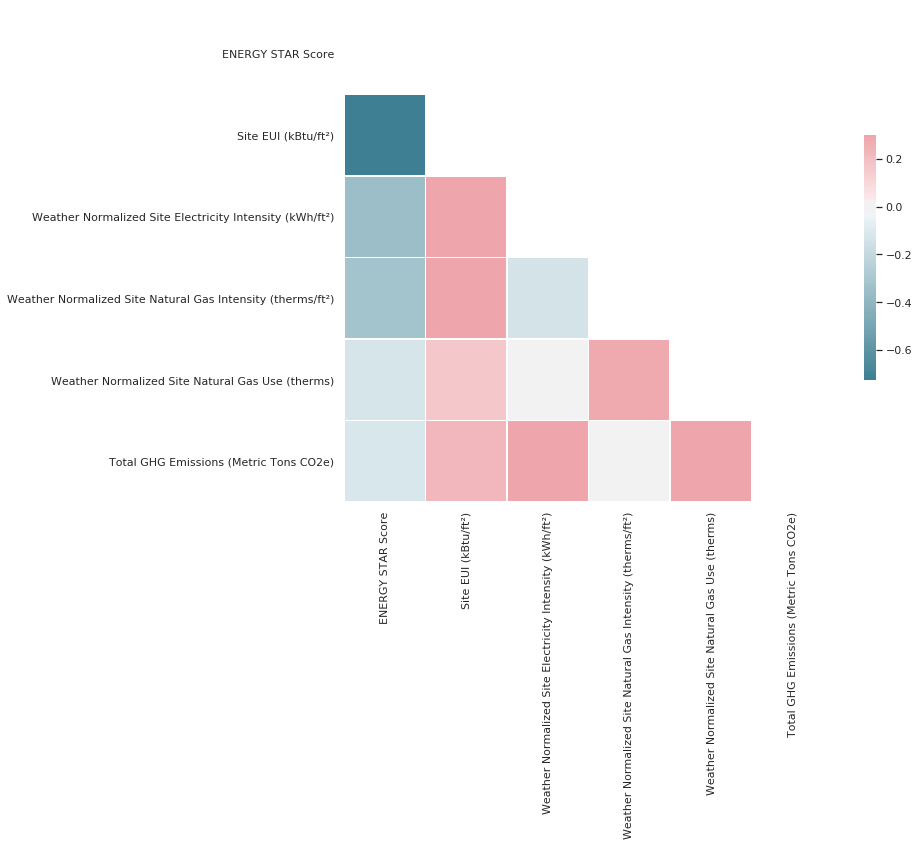

In [23]:
# Gráfico de Correlação
sns.set(style = "white")

# Compute the correlation matrix
corr = dataset_treino.corr(method = 'pearson')

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap = True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

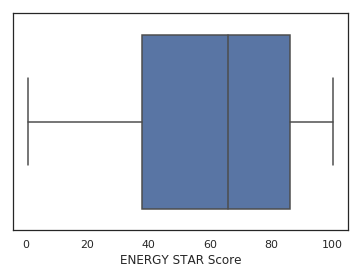

In [24]:
# Boxplot
sns.boxplot(dataset_treino["ENERGY STAR Score"])
plt.show()

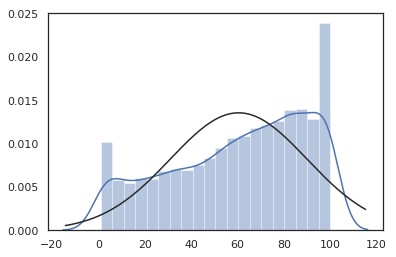

In [25]:
# Distplot
sns.distplot(tuple(dataset_treino["ENERGY STAR Score"]), fit = stats.norm)
plt.show()

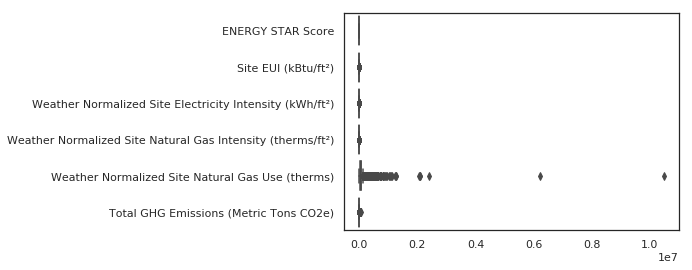

In [26]:
# Boxplot das Variaveis Restantes (ha outliers)
sns.boxplot(data = dataset_treino[["ENERGY STAR Score", "Site EUI (kBtu/ft²)", 
               "Weather Normalized Site Electricity Intensity (kWh/ft²)", "Weather Normalized Site Natural Gas Intensity (therms/ft²)",
               "Weather Normalized Site Natural Gas Use (therms)", "Total GHG Emissions (Metric Tons CO2e)"]],
            orient = "h")
plt.show()

In [27]:
# Retirando os outliers
coluna_out = "Weather Normalized Site Natural Gas Use (therms)"
mean = np.mean(dataset_treino[coluna_out])
sd = np.std(dataset_treino[coluna_out])
out = mean + 2*sd
dataset_treino = dataset_treino.drop(dataset_treino[dataset_treino[coluna_out] > out].index)

coluna_out = "Weather Normalized Site Natural Gas Intensity (therms/ft²)"
mean = np.mean(dataset_treino[coluna_out])
sd = np.std(dataset_treino[coluna_out])
out = mean + 2*sd
dataset_treino = dataset_treino.drop(dataset_treino[dataset_treino[coluna_out] > out].index)

coluna_out = "Weather Normalized Site Electricity Intensity (kWh/ft²)"
mean = np.mean(dataset_treino[coluna_out])
sd = np.std(dataset_treino[coluna_out])
out = mean + 2*sd
dataset_treino = dataset_treino.drop(dataset_treino[dataset_treino[coluna_out] > out].index)

coluna_out = "Site EUI (kBtu/ft²)"
mean = np.mean(dataset_treino[coluna_out])
sd = np.std(dataset_treino[coluna_out])
out = mean + 2*sd
dataset_treino = dataset_treino.drop(dataset_treino[dataset_treino[coluna_out] > out].index)

coluna_out = "Total GHG Emissions (Metric Tons CO2e)"
mean = np.mean(dataset_treino[coluna_out])
sd = np.std(dataset_treino[coluna_out])
out = mean + 2*sd
dataset_treino = dataset_treino.drop(dataset_treino[dataset_treino[coluna_out] > out].index)

**Preparação dos Dados para o Modelo**

In [28]:
# Transformando as variaveis Categoricas restantes em Dummies
coluna_cat = ["Primary Property Type - Self Selected",  "Metered Areas (Energy)", 'BBL - 10 digits','Water Required?']
dummies = pd.get_dummies(dataset_treino[coluna_cat])
dummies_teste = pd.get_dummies(dataset_teste[coluna_cat])

final_train, final_test = dummies.align(dummies_teste,join='left',axis=1)

In [29]:
# Separando as Colunas Categoricas das Numericas
coluna_num = ["Site EUI (kBtu/ft²)", 
               "Weather Normalized Site Electricity Intensity (kWh/ft²)", "Weather Normalized Site Natural Gas Intensity (therms/ft²)",
               "Weather Normalized Site Natural Gas Use (therms)", "Total GHG Emissions (Metric Tons CO2e)"]

target = "ENERGY STAR Score"

In [30]:
# Transformando os dados para a mesma escala (entre 0 e 1)

X = dataset_treino[coluna_num].values
Y_target = dataset_treino[target].values

X_teste = dataset_teste[coluna_num].values

# Gerando a nova escala
scaler = MinMaxScaler(feature_range = (-1, 1)).fit(X)
rescaledX = scaler.transform(X)

rescaledX_teste = scaler.transform(X_teste)

In [31]:
# Juntando os resultados de transformacao dos dados 
data_modelo = dataset_treino[coluna_num].copy()
data_modelo[coluna_num] = rescaledX
data_modelo = data_modelo.join(final_train)

data_modelo_teste = dataset_teste[coluna_num].copy()
data_modelo_teste[coluna_num] = rescaledX_teste
data_modelo_teste = data_modelo_teste.join(final_test)

In [32]:
data_modelo_teste[np.isnan(data_modelo_teste)] = 0

In [33]:
X_treino = data_modelo.values
Y_treino = Y_target

**Ajustando o Modelo**

In [34]:
# Criando modelo de Machine Learning a partir de cada algoritmo, ja ajustado os parametros por GridSearchCV
# Vamos utilizar como métrica o MAE (Mean Absolute Error). Valor igual a zero indica excelente nível de precisão.
modelos = []

modelos.append(('GBM', GradientBoostingRegressor(n_estimators = 270, loss = 'huber', max_depth = 4,
                                                 learning_rate = 0.05, subsample = 0.7)))
modelos.append(('XG', XGBRegressor(n_estimators = 300, max_depth = 4, learning_rate = 0.05,
                                   gamma = 0.3, subsample= 0.75, min_child_weight = 0.5)))
resultados = []
nomes = []

# Percorrendo cada um dos modelos
for nome, modelo in modelos:
    kfold = model_selection.KFold(50, True, random_state = 7)
    cross_val_result = model_selection.cross_val_score(modelo, 
                                                        X_treino, 
                                                        Y_treino, 
                                                        cv = kfold, scoring = 'neg_mean_absolute_error')
    resultados.append(cross_val_result)
    nomes.append(nome)
    texto = "%s: %f (%f)" % (nome, cross_val_result.mean(), cross_val_result.std())
    print(texto)

GBM: -9.017179 (0.866139)
XG: -9.146903 (0.842157)


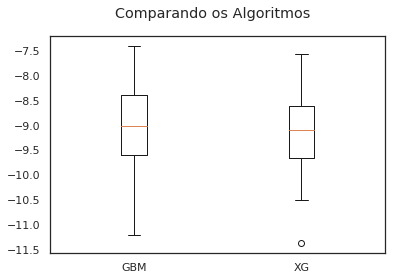

In [35]:
# Comparando os algoritmos
fig = plt.figure()
fig.suptitle('Comparando os Algoritmos')
ax = fig.add_subplot(111)
plt.boxplot(resultados)
ax.set_xticklabels(nomes)
plt.show()

**Previsao**

In [36]:
# Modelo GBM
model_gbm = GradientBoostingRegressor(n_estimators = 270, loss = 'huber', max_depth = 4,
                                      learning_rate = 0.05, subsample = 0.7)
model_gbm.fit(X_treino,Y_treino)
previsoes_final_gbm = model_gbm.predict(data_modelo_teste.values)

In [37]:
# Ajustando os resultados para ficarem entre 1-100
for i in range(0,len(previsoes_final_gbm)):
        if previsoes_final_gbm[i] > 100:
            previsoes_final_gbm[i] = 100          

In [38]:
# Ajustando os resultados para ficarem entre 1-100
for i in range(0,len(previsoes_final_gbm)):
        if previsoes_final_gbm[i] < 1:
            previsoes_final_gbm[i] = 1

In [39]:
# Transformando as previsoes em numeros inteiros
previsoes_final = previsoes_final_gbm.round(0).astype('int')

In [40]:
dataset_test_submission = pd.read_csv("../input/dataset_teste.csv", index_col = 'Property Id')
dataset_test_submission['score'] = previsoes_final
Submission = dataset_test_submission['score']
Submission = pd.DataFrame(Submission);Submission.head(10)

,score
Property Id,
2637863,87
4988569,80
3129181,74
3129231,32
2658438,100
2646962,100
2746882,89
2658502,100
3114587,100


In [41]:
Submission.to_csv('Submission.csv', header = True)